## Creating csv files of Nodes as well as Edges
## Exploratory Data Analysis (EDA)

In [98]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stopWords = stopwords.words('english')

import os
import re
import csv
import numpy as np
import csv 

In [287]:
data = pd.read_csv('preprocessed_data.csv')

### creating word emmbeding vector and cosine similarity matrix

In [288]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

text_data = data.iloc[:, 1].astype(str)

vectorizer = CountVectorizer()

vectorized_text = vectorizer.fit_transform(text_data)

cosine_similarity_matrix = cosine_similarity(vectorized_text)
cosine_similarity_matrix = cosine_similarity(vectorized_text)-np.eye(np.shape(cosine_similarity_matrix)[0])

# print("Cosine Similarity Matrix:")
# print(cosine_similarity_matrix)
# np.where(cosine_similarity_matrix == 1)[1]

In [289]:
cosine_similarity_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.11022302e-16,  5.47722558e-01, ...,
         3.38061702e-01,  4.47213595e-01,  0.00000000e+00],
       [ 0.00000000e+00,  5.47722558e-01,  2.22044605e-16, ...,
         3.08606700e-01,  4.08248290e-01,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  3.38061702e-01,  3.08606700e-01, ...,
        -3.33066907e-16,  5.66946710e-01,  1.54303350e-01],
       [ 0.00000000e+00,  4.47213595e-01,  4.08248290e-01, ...,
         5.66946710e-01,  0.00000000e+00,  2.04124145e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.54303350e-01,  2.04124145e-01,  2.22044605e-16]])

### Setting a threshhold value for achieving a network with density of about 1%


In [290]:
def binarizing(x, tr):
  x[x>=tr] = 1
  x[x<tr] = 0
  return x
cosine_similarity_matrix = binarizing(cosine_similarity_matrix, 0.37)

In [292]:
(cosine_similarity_matrix == 1).sum()/ (935*935)

0.008354828562441019

In [291]:
(cosine_similarity_matrix == 1).sum()

7304

### Creating Adjacency Matrix of the cosine similarity matrix

#### Loading nodes and edges into csv files 

In [293]:
# Example adjacency matrix
adjacency_matrix = cosine_similarity_matrix  # Your adjacency matrix here
labels = data['disease']

# Create a DataFrame for edges
edges_df = pd.DataFrame(np.argwhere(adjacency_matrix == 1), columns=['Source', 'Target'])

# Write edge list to CSV file
edges_df.to_csv("edges.csv", index=False)
labels.to_csv("nodes.csv")

### Loadding the network into Network x object

In [294]:
G = nx.read_edgelist('./edges.csv', comments='#',
                     create_using=nx.Graph(), 
                     delimiter=',', 
                     nodetype=int, 
                     encoding='utf-8')

### EDA

In [295]:
N = len(G)
L = G.size()
degrees = [G.degree(node) for node in G]
kmin = min(degrees)
kmax = max(degrees)

print("Number of nodes: ", N)
print("Number of edges: ", L)
print()
print("Average degree: ", 2*L/N)
print("Average degree (alternate calculation)", np.mean(degrees))
print()
print("Minimum degree: ", kmin)
print("Maximum degree: ", kmax)

Number of nodes:  639
Number of edges:  3652

Average degree:  11.43035993740219
Average degree (alternate calculation) 11.43035993740219

Minimum degree:  1
Maximum degree:  105


In [296]:
# Get 20 logarithmically spaced bins between kmin and kmax
bin_edges = np.linspace(kmin, kmax, num=10)

# histogram the data into these bins
density, _ = np.histogram(degrees, bins=bin_edges, density=True)

In [297]:
# Get 10 logarithmically spaced bins between kmin and kmax
bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=10)

# histogram the data into these bins
density, _ = np.histogram(degrees, bins=bin_edges, density=True)

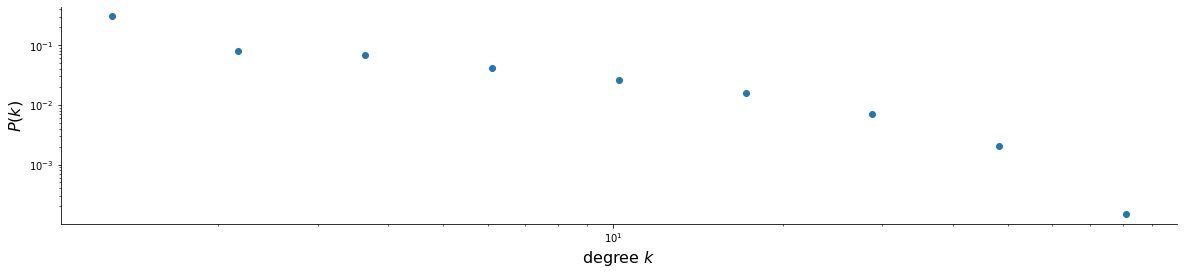

In [298]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,4))

# "x" should be midpoint (IN LOG SPACE) of each bin
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.loglog(x, density, marker='o', linestyle='none')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)

# remove right and top boundaries because they're ugly
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Show the plot
plt.show()

In [299]:
nx.is_connected(G)
nx.number_connected_components(G)

26